INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


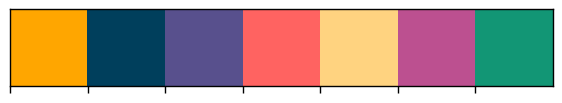

In [313]:
# Importaciones de bibliotecas estándar
# Importaciones de bibliotecas de sistema
import os
import gc
import time
import shutil

# Importaciones de bibliotecas de terceros
import wget
import scipy.signal
import h5py
import psutil
import ray

# Importaciones de TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from keras import backend as K 

# Importaciones de sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.datasets import make_classification
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
# Importaciones de pandas
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# Importaciones de matplotlib
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

from matplotlib.ticker import FormatStrFormatter
from IPython.core.pylabtools import figsize, getfigs
%matplotlib inline

# Importaciones de seaborn
import seaborn as sns
gyr = ["#ffa600",
        '#003f5c',
       "#58508d",
       "#ff6361",
       "#ffd380",
       "#bc5090",
       "#129675"
      ]
palet = sns.palplot(sns.color_palette(gyr))
sns.set_context("paper")

# Importaciones de plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Importaciones de numpy
import numpy as np

# Importaciones de astropy
from astropy.io import fits
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
import astropy.units as u

# Importaciones para el equilibrio de los datos
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import RandomUnderSampler


# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

# Obtén el número de CPUs
num_cpus = psutil.cpu_count(logical=False)


class BalancedDataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras Sequence based data generator. 
       Suitable for building data generator for training and prediction.
    """
    def __init__(self, x, y, batch_size=64):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y)
        self.class_indices = [np.where(y == i)[0] for i in self.classes]
        self.length = min([len(i) for i in self.class_indices]) // self.batch_size * len(self.classes)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        for class_index in self.class_indices:
            i = idx % (len(class_index) // self.batch_size)
            batch_x.append(self.x[class_index[i * self.batch_size:(i + 1) * self.batch_size]])
            batch_y.append(self.y[class_index[i * self.batch_size:(i + 1) * self.batch_size]])
        return np.concatenate(batch_x), np.concatenate(batch_y)

    def on_epoch_end(self):
        for class_index in self.class_indices:
            np.random.shuffle(class_index)


# Funciones
def descarga_wget(database,ID,path_3,path_4):
    _,field,types,_ = ID.lower().split("-")
    try :
        if types=="ell":
            types="ecl"
        if database==4:
            if ((field =="blg") |(field =="gd"))&((types =="ecl")|(types =="lpv")|(types =="dsct")):
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot_ogle4/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
            else:
                url = "http://ftp.astrouw.edu.pl/ogle/ogle4/OCVS/"+field+"/"+types+"/phot/I/"+ ID +".dat"
                wget.download(url,path_4)
                return 1
                
        if database==3:
            url = "http://ftp.astrouw.edu.pl/ogle/ogle3/OIII-CVS/" +field+"/"+types+"/phot/I/"+ ID +".dat"
            wget.download(url,path_3)
            return 1
    except:
        return 0
            
@ray.remote
def review_open_data(nomb,path_datos,database):
        path= path_datos[database]
        try :
            df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["jd","mag","err"])
            df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )]
            obs_eliminadas = len(df) - len(df_sigma)
            amplitud = df_sigma["mag"].max() - df_sigma["mag"].min()
            mag_mean = df_sigma["mag"].mean()
            mag_std = df_sigma["mag"].std()
            err_mean = df_sigma["err"].mean()
            err_std = df_sigma["err"].std()
            obs_final = len(df_sigma)
            obs_inicial = len(df)
            return 1,nomb,database,obs_eliminadas,amplitud,mag_mean,mag_std,err_mean,err_std,obs_final,obs_inicial
        except:
            return 0,nomb,database,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

        
def ra_dec_to_degrees(ra_str, dec_str):
    # Convertir las coordenadas RA y DEC en objetos SkyCoord
    coord = SkyCoord(ra=ra_str, dec=dec_str, unit=(u.hourangle, u.deg))

    # Obtener las coordenadas en grados
    ra_deg = coord.ra.degree
    dec_deg = coord.dec.degree

    return ra_deg, dec_deg

def fase_datos(path_datos,database,nomb,per_vsx):
    path= path_datos[database]
    df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["jd","mag","err"])
    df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )]
    if len(df_sigma)>2000:
        df_sigma = df_sigma.sample(2000,random_state=42).reset_index(drop=True)
    fase_vsx = np.mod(df_sigma.jd, per_vsx) / per_vsx
    mag_vsx,t_vsx,err_vsx =df_sigma.mag,df_sigma.jd,df_sigma.err
    return fase_vsx,mag_vsx,t_vsx

def make_2d_histogram(n_bins_x,n_bins_y,data_mag,data_fase,norm_max):
    bins_x = np.linspace(0,1, n_bins_x) # Curves in phase between 0 and 2.
    bins_y = np.linspace( data_mag.min(), data_mag.max(), n_bins_y)
    hist_data, _xbins, _ybins = np.histogram2d(data_fase, data_mag, bins=(bins_x, bins_y))
    # Data in histogram is transposed, then transpose it just once:
    if norm_max=="max":
        norm_max = hist_data.max()
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu
    else:
        norm_max = float(norm_max)
        hist_data[hist_data > norm_max ] = norm_max
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu

def split_random(df,numero_dividir,col_name):
    for types in df["types"].unique():
        df_var = df.loc[df["types"]==types].sample(numero_dividir,random_state=42)
        df_train,df_test = train_test_split(df_var,random_state=42,test_size=0.13)
        df_train,df_val = train_test_split(df_train,random_state=42,test_size=0.15)
        df.loc[df_train.index,col_name] = "train"
        df.loc[df_val.index,col_name] = "val"
        df.loc[df_test.index,col_name] = "test"
    return df
    

def split_data_balanced(df,numero_dividir):
    df["combined"] = list(zip(df["obs_final"],
                          df["amplitud"],
                          df["mag_mean"],
                          df["mag_std"],
                          df["field"],
                         df["err_mean"],
                         df["per"],
                         df["err_std"]))
    combined_weight = df['combined'].value_counts(normalize=True)
    df['combined_weight'] = df['combined'].apply(lambda x: combined_weight[x])
    subsample = df.sample(numero_dividir, weights=df['combined_weight'])
    for types in df["types"].unique():
        df_var = df.loc[df["types"]==types].sample(numero_dividir,
                                                             weights=df['combined_weight'],
                                                             random_state=42)
        df_train = df_var.sample(frac=0.8,
                         weights=df['combined_weight'],
                         random_state=42)
        df_var = df_var.drop(df_train.index)
        
        df_val = df_var.sample(frac=0.5,
                         weights=df['combined_weight'],
                         random_state=42)
        
        df_test = df_var.drop(df_val.index)
        
        df.loc[df_train.index,"entrenamiento_8mil_balanced"] = "train"
        df.loc[df_val.index,"entrenamiento_8mil_balanced"] = "val"
        df.loc[df_test.index,"entrenamiento_8mil_balanced"] = "test"
            
        
    return df

def plot_obs_dist(df,split_name):
    sns.set_context("paper")
    gyr = ["#890B96",'#FFCF3D',"#129675"]
    sns.set_palette(gyr)

    columns = ["obs_final", "amplitud", "mag_mean", "field", "err_mean", "per", "mag_std", "err_std"]
    labels = [r'$n_{obs}$', r'$Amplitude$', 'Mean Magnitude', "Field", 'Mean Error', 'Period', 
              'Magnitude standard deviations', 'Magnitude Error standard deviations']
    log_scales = [True, True, False, False, True, True, True, False]
    x_ticks = [[10**2,10**3,10**4], [10**-1,1,10**1], None, None, [10**-2,10**-1,10**0], [10**-1,10**1,10**3],
               None, [0,0.3,0.6]]
    y_scale_log = [False, False, False, False, False, False, False, True]

    fig, axes = plt.subplots(4, 2, figsize=(7,15))

    for i, ax in enumerate(axes.flatten()):
        sns.histplot(ax=ax, data=df, x=columns[i], hue=split_name, bins=30,
                     stat="density", log_scale=log_scales[i], fill=True, common_norm=True)
        ax.set(xlabel=labels[i], ylabel="")
        if x_ticks[i] is not None:
            ax.set_xticks(x_ticks[i])
        if y_scale_log[i]:
            ax.set_yscale("log")
        if i != 0: # remove legend for all but the first subplot
            ax.get_legend().remove()

    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13)
    fig.tight_layout()
    fig.text(-0.01,0.5,"Density", size=13, rotation=90)
    fig.tight_layout()
    


@ray.remote
def make_lc_hist(nomb,
                 per_vsx,
                 path_datos,
                 database,
                 aug,
                 rng,
                 g,
                 bins,
                N):
        path= path_datos[database]
        df = pd.read_csv(f"{path}/{nomb}.dat",delim_whitespace=True,names=["d","mag","e"])
        df_sigma = df.loc[(df["mag"] < np.mean(df["mag"]) + 3*np.std(df["mag"])) & ( df["mag"] > np.mean(df["mag"]) - 3*np.std(df["mag"]) )].reset_index(drop=True)
        if int(aug) == 0:
            df_sigma["fase"] = np.mod(df_sigma.d, per_vsx) / per_vsx
            if len(df_sigma)>2000:
                df_sigma = df_sigma.sample(2000,random_state=42)
            hdu =make_2d_histogram(32+1,32+1,df_sigma.mag,df_sigma.fase, norm_max=7)
            return hdu.data
        
        if int(aug) == 1:
            df_sigma["fase"] =  np.mod(df_sigma.d - g, per_vsx) / per_vsx
            df_sigma["mag"] = df_sigma["mag"] + rng.normal(0, df_sigma["e"],len(df_sigma))
            df_sigma["fase_bin"] = pd.cut(df_sigma["fase"],bins=int(bins))
            df_bins = pd.DataFrame(df_sigma.groupby("fase_bin")["fase"].mean())
            df_bins["mag"] = df_sigma.groupby("fase_bin")["mag"].mean()
            df_bins["e"] = df_sigma.groupby("fase_bin")["e"].mean()
            df_bins["d"] = df_sigma.groupby("fase_bin")["d"].mean()
            hdu =make_2d_histogram(32+1,32+1,df_bins.mag,df_bins.fase,norm_max=N)
            return hdu.data

def create_hdf5(df,path_datos,rng):
    results_ids = []
    for i in range(len(df)):
        hdu = make_lc_hist.remote(df["ID"][i],
                                  df["per"][i],
                                  path_datos,
                                  df["database"][i],
                                  df["aug"][i],
                                  rng,
                                  df["g"][i],
                                  df["bins"][i],
                                 df["N"][i])
        results_ids.append((hdu))
    x = np.empty((len(df), 32, 32))
    for i,key in enumerate(results_ids):
        ima = ray.get(key)
        x[i] = ima
    x = np.expand_dims(x, axis=3)
    return x

def make_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(32, 32, 1),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(16, (3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3),activation="relu",padding="same"),
    tf.keras.layers.Conv2D(32, (3, 3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.3),
   # tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=0.1), loss="sparse_categorical_crossentropy", metrics=['acc'])
    return model

def train_models(df_lista, keys_lista, data, prueba_8mil,epochs=200, use_balanced_generator=False):
    tf.random.set_seed(42)

    validation_datagen = ImageDataGenerator()
    idx_val = prueba_8mil.loc[prueba_8mil['prueba_13080mil']=="val"].index.values
    val_label = data['prueba_13080mil_label'][idx_val]
    val_data = data["prueba_13080mil"][idx_val]
    val_gen = validation_datagen.flow(val_data, val_label, batch_size=32, shuffle=True)

    for df, test_name in zip(df_lista, keys_lista):
        K.clear_session()
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        model_history_log_file = f"history_softmax_{'batchBalanced_' if use_balanced_generator else ''}{test_name}.csv"
        csv_logger = CSVLogger(model_history_log_file, append=False)

        checkpoint_path = f"training_softmax_{'batchBalanced_' if use_balanced_generator else ''}{test_name}/cp.ckpt"
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=False, verbose=1)

        callbacks = [csv_logger, cp_callback, early_stopping]
        
        if use_balanced_generator:
            idx_train = df.loc[(df[test_name]!="test")&(df[test_name]!="val")&(df["aug"]==0)].index.values
        else :
            idx_train = df.loc[(df[test_name]!="test")&(df[test_name]!="val")].index.values

        bz = int((len(idx_train) * 64)/ len(prueba_8mil.loc[prueba_8mil['prueba_13080mil']=="train"]))
    
        train_label = data[f'{test_name}_label'][idx_train]
        
        train_data = data[test_name][idx_train]
        
        if use_balanced_generator:
            train_gen = BalancedDataGenerator(train_data, train_label, batch_size=64)
        else:
            train_datagen = ImageDataGenerator()
            train_gen = train_datagen.flow(train_data, train_label, batch_size=bz, shuffle=True)

        model = make_model()
        print(f"Use balanced Generator [{use_balanced_generator}] \n Data: {len(train_data)} \n -----------------------------------------------------------------------------------")
        history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
    return

    
def augmented_to(ID,count,df):
    a = (np.linspace(0,9,count)*100).astype(int)
    np.sort(rng.uniform(low=0 + 1/32, high=1 - 1/32, size=1000))[a]
    df.loc[df["ID"]==ID,"g"] = np.sort(rng.uniform(low=0 + 1/32, high=1 - 1/32, size=1000))[a]
    return

def plot_accuracy_and_loss(path,file_names, title_names, amarillo_train, purpura_val, output_file="training_.pdf"):
    plt.rcParams["figure.figsize"] = (18,8)
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(2, len(file_names), sharex="col", sharey="row")
    metrics = ["acc", "val_acc", "loss", "val_loss"]
    labels = ['Training data Augmentation', 'Validation data Augmentation', 'Training data Augmentation', 'Validation data Augmentation']
    labels_batch = ['Training batch balanced', 'Validation batch balanced', 'Training batch balanced', 'Validation batch balanced']    
    colors = [amarillo_train, purpura_val, amarillo_train, purpura_val]
    linestyles = ["-.", ".as", "dashdot", "dashdot"]

    for i, file_name in enumerate(file_names):
        batch_name = file_name.split("softmax")[0]+"softmax_batchBalanced"+file_name.split("softmax")[1]
        df = pd.read_csv(f"{path}/{file_name}.csv")
        df_batch = pd.read_csv(f"{path}/{batch_name}.csv")

        for j, metric in enumerate(metrics):
            sns.lineplot(ax=axs[j//2, i], data=df, x="epoch", y=metric, 
                         color=colors[j], label=labels[j], linestyle="solid")
            if i > 0:
                sns.lineplot(ax=axs[j//2, i], data=df_batch, x="epoch", y=metric, 
                             color=colors[j], label=labels_batch[j], linestyle="dashed")

        axs[0,i].set_title(title_names[i])
        axs[0,i].set_ylim([0.6,1])
        axs[1,i].set_ylim([0.6,1])
        axs[0,i].set_yticks(np.linspace(0.6,1,8))
        axs[1,i].set_yticks(np.linspace(0,0.9,8))
        axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[1,i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[1,i].set_xlabel('Epoch')

        axs[0,i].get_legend().remove()
        axs[1,i].get_legend().remove()

    axs[0,0].set_ylabel('Accuracy')
    axs[1,0].set_ylabel('Loss')

    handles, labels = axs[1,2].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.19,0.5), ncol=4, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.savefig(output_file, bbox_inches="tight")
    return
def run_analysis(tests,titles,entrenamiento,filename="../data_Paper_OGLE/Data_08Sep.hdf5",
                 csv_file="../data_Paper_OGLE/catalogos/prueba_8mil.csv"):
    # Load data
    data = h5py.File(filename, 'r+')
    df_8mil = pd.read_csv(csv_file)
    idx_test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"].index.values
    test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"]
    test = test.drop(columns={"prueba_8mil","aug","g","bins","GroupID","GroupSize"})
    
    # Prepare data generator
    test_datagen = ImageDataGenerator()
    test_gen = test_datagen.flow(
        data["prueba_13080mil"][idx_test],
        data["prueba_13080mil_label"][idx_test],
        batch_size=32
    )
    
    sns.set_context("paper",font_scale=3)
    model = make_model()

    num_tests = len(tests)
    rows = 2  # Ahora queremos 2 filas
    cols = 3  # Y 3 columnas

    fig, ax = plt.subplots(rows, cols, figsize=(11*3, 10*2), sharey="row")
    plt.subplots_adjust(wspace=0, hspace=0.2, right=0.7)

    # Aplanar el array de ejes para iterar fácilmente
    ax = ax.ravel()

    for i, prueba in enumerate(tests):
        model.load_weights(f"{entrenamiento}/{prueba}/cp.ckpt")
        prediction(test, test_gen, model, prueba)

        # Calculate F1 Score
        f1 = f1_score(test_gen.y, test[f"label_predict_{prueba}"], average='weighted')

        # Plots
        array, annot = C_M(test_gen.y, test[f"label_predict_{prueba}"])
        sns.heatmap(array, annot=annot, fmt='', vmin=0, vmax=np.sum(array, axis=1)[0], cmap="BuPu",
                    annot_kws={"fontsize":25}, linewidth=1, ax=ax[i], cbar=False)
        ax[i].set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])
        ax[i].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])
        ax[i].set_yticklabels(['ELL', 'Mira', 'CEP', 'DST', 'ECL', 'LPV', 'RRL', "Rndm"])
        ax[i].set_xticklabels(['ELL', 'Mira', 'CEP', 'DST', 'ECL', 'LPV', 'RRL', "Rndm"], rotation=45)
        prueba = prueba.split("prueba")[1]
        # Add title and F1 Score
        ax[i].set_title(f'{titles[i]}\nF1 Score: {f1:.3f}')

    # Eliminar el último subplot si el número de tests no llena todos los subplots
    if num_tests < rows * cols:
        fig.delaxes(ax[-1])

    # Etiqueta general para el eje y
    fig.text(-0.02, 0.5, 'True Label', va='center', rotation='vertical', fontsize=30)

    # Etiqueta general para el eje x
    fig.text(0.5, -0.02, 'Predicted Label', ha='center', fontsize=30)

    fig.tight_layout(pad=0)
    plt.savefig("CM.pdf", bbox_inches="tight")
    return test

def prediction(df,image_gen,model,prueba):
    %matplotlib inline
    grupos = ['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"random"]
    label_predict = []
    porcentaje_predict = []
    nombres = []
    for i in model.predict(image_gen.x):
        idx = np.argmax(i)
        label_predict.append(np.argmax(i))
        porcentaje_predict.append(i[idx])
        nombres.append(grupos[np.argmax(i)])
    df[f"label_predict_{prueba}"] = label_predict
    df[f"porcentaje_predict_{prueba}"] = porcentaje_predict
    df[f"nombres_predict_{prueba}"] = nombres
    return

def C_M(label,predict_label):
    array = np.array(tf.math.confusion_matrix(label,predict_label) )
    df = pd.DataFrame(array)
    perc = df.copy()
    cols=perc.columns.values
    perc[cols]=perc[cols].div(perc[cols].sum(axis=1), axis=0).multiply(100)
    annot=df.round(2).astype(str) + "\n" + perc.round(1).astype(str) + "%"
    return array,annot

def metricas(labels,predict):
    print("Accuracy:", "%0.2f" % metrics.accuracy_score(labels,predict))
    print("macro precision: ","%0.2f" %  metrics.precision_score(labels,predict, average='macro'))
    print("macro recall: ","%0.2f" %  metrics.recall_score(labels,predict, average='macro'))
    print("macro F1: ","%0.2f" %  metrics.f1_score(labels,predict, average='macro'))
    print(metrics.classification_report(labels,predict, digits=2))
    report = metrics.classification_report(labels,predict, output_dict=True, digits=2)
    return report

def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=500, random_state=42):
    # Crea el clasificador Random Forest
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Entrena el clasificador
    clf.fit(X_train, y_train)
    
    # Predice las clases para el conjunto de test
    y_pred = clf.predict(X_test)
    
    # Crea una figura y ejes para la trama
    fig, ax = plt.subplots(figsize=(8, 8))

    array, annot = C_M(y_test, y_pred)
    sns.heatmap(array, annot=annot, fmt='', vmin=0, vmax=np.sum(array, axis=1)[0], cmap="BuPu",
                annot_kws={"fontsize":15}, linewidth=1, ax=ax, cbar=False)
    
    ax.set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    ax.set_yticklabels(['ELL', 'Mira', 'CEP', 'DST', 'ECL', 'LPV', 'RRL'], fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    
    ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    ax.set_xticklabels(['ELL', 'Mira', 'CEP', 'DST', 'ECL', 'LPV', 'RRL'], fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=20)
    
    # Add title and F1 Score
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    ax.set_title(f'Random Forest\nF1 Score: {f1:.2f}', fontsize=20)

    fig.tight_layout(pad=0)
    plt.savefig("CNN_And_RF.pdf", bbox_inches="tight")

    return clf, y_pred

from sklearn import tree


def train_tree(X_train, y_train, X_test, y_test, max_depth, random_state=42):
    # Crea el clasificador Random Forest
    clf = tree.DecisionTreeClassifier(max_depth=max_depth,random_state=42)
    
    # Entrena el clasificador
    clf.fit(X_train, y_train)
    
    # Predice las clases para el conjunto de test
    y_pred = clf.predict(X_test)
    
    # Crea una figura y ejes para la trama
    fig, ax = plt.subplots(figsize=(8, 8))

    array, annot = C_M(y_test, y_pred)
    sns.heatmap(array, annot=annot, fmt='', vmin=0, vmax=np.sum(array, axis=1)[0], cmap="BuPu",
                annot_kws={"fontsize":15}, linewidth=1, ax=ax, cbar=False)
    
    ax.set_yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    ax.set_yticklabels(['ELL', 'Mira', 'Cep', 'Dsct', 'Ecl', 'Lpv', 'RRlyr'], fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    
    ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    ax.set_xticklabels(['ELL', 'Mira', 'Cep', 'Dsct', 'Ecl', 'Lpv', 'RRlyr'], fontsize=20)
    ax.set_xlabel('Predicted Label', fontsize=20)
    
    # Add title and F1 Score
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    ax.set_title(f'Random Forest\nF1 Score: {f1:.2f}', fontsize=20)

    fig.tight_layout(pad=0)
    plt.savefig("CNN_And_RF.pdf", bbox_inches="tight")

    return clf, y_pred

path = "/home/nicolas/nico/Data/data_Paper_OGLE/"

datos = f"{path}Data/datos_ogle/datos"

path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

rng = np.random.default_rng(42)
#path = "/home/nicolas/nico/Data/data_Paper_OGLE/7_01_2024/"

In [271]:
catalog = pd.read_csv(f"{path}/7_01_2024//0_Catalog_TimeSerieInformation_DT_unique.csv")
catalog = catalog.loc[catalog["per"]!=0]

In [279]:
def make_2d_histogram(n_bins_x,n_bins_y,data_mag,data_fase,norm_max="max"):
    bins_x = np.linspace(0,1, n_bins_x) # Curves in phase between 0 and 2.
    bins_y = np.linspace( data_mag.min(), data_mag.max(), n_bins_y)
    hist_data, _xbins, _ybins = np.histogram2d(data_fase, data_mag, bins=(bins_x, bins_y))
    # Data in histogram is transposed, then transpose it just once:
    if norm_max=="max":
        norm_max = hist_data.max()
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu
    if norm_max=="none":
        hist_data_norm = hist_data
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu
    
    else:
        norm_max = float(norm_max)
        hist_data[hist_data > norm_max ] = norm_max
        hist_data_norm = hist_data / norm_max
        hist_data_transposed = hist_data_norm.transpose()
        hdu = fits.PrimaryHDU(data=hist_data_transposed)
        return hdu

In [337]:
import numpy as np
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

def plot_histograms(estrellas_plot,path_datos, norm):
    
    fig, ax = plt.subplots(len(estrellas_plot), 2, figsize=(6, 10), sharex="col")
    for i in range(len(estrellas_plot)):
        fase, mag, t_vsx = fase_datos(path_datos, estrellas_plot["database"][i], estrellas_plot["ID"][i], estrellas_plot["per"][i])

        ax[i, 0].set_ylim(mag.max(), mag.min()- (mag.max() - mag.min())/4)
        ax[i, 0].set_yticks(np.linspace(mag.min() + (mag.max() - mag.min()) / 10, mag.max() - (mag.max() - mag.min()) / 10, 4))
        ax[i, 0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sns.scatterplot(x=fase, y=mag, c=t_vsx, s=5, ax=ax[i, 0])

        # Agregar el nombre de la estrella y el tipo en la esquina superior izquierda
        text = f"{estrellas_plot['ID'][i]} [{estrellas_plot['types'][i]}]"
        ax[i, 0].text(0.05, 0.95, text, transform=ax[i, 0].transAxes, fontsize=9, verticalalignment='top')

        hdu = make_2d_histogram(32 + 1, 32 + 1, mag, fase, norm_max=norm)
        ax[i, 1].imshow(hdu.data, interpolation='nearest', aspect='auto')
        ax[i, 1].set_yticklabels([])
        ax[i, 1].set_xticklabels([])

    fig.text(0.5, 0, "Phase", size=13)
    fig.text(-0.01, 0.5, "I Mag", size=13, rotation=90)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig("hist_2d_fase.pdf", bbox_inches="tight", pad_inches=0)
    return hdu


In [305]:
estrellas = ['OGLE-GD-RRLYR-04519', 'OGLE-BLG-LPV-240852', "OGLE-SMC-ECL-2344", "OGLE-LMC-CEP-2430", 'OGLE-LMC-LPV-83641', "OGLE-BLG-DSCT-00245", "OGLE-BLG-ELL-007122"]


catalog = pd.read_csv(f"{path}/7_01_2024//0_Catalog_TimeSerieInformation_DT_unique.csv")
catalog = catalog.loc[catalog["per"]!=0]

estrellas_plot = catalog.loc[catalog["ID"].isin(estrellas)].reset_index(drop=True)

random = pd.read_csv(f"{path}/7_01_2024/train_number_M.csv")
rndm = random.loc[random["categorical_label"]==7].sample(1).reset_index(drop=True)
rndm["types"]="Random"

estrellas_plot = pd.concat([estrellas_plot,rndm]).reset_index(drop=True)

replacement_dict = {
    "cep": "CEP",
    "ecl": "E",
    "dsct": "DST",
    "ELL": "ELL",
    "Mira": "M",
    "rrlyr": "RR",
    "lpv": "LPV",
    "Random": "Rndm"
}

estrellas_plot["types"] = estrellas_plot["types"].replace(replacement_dict)

a = plot_histograms(estrellas_plot, path_datos,"max")


In [306]:
estrellas_plot = catalog.loc[catalog["ID"].isin(estrellas)].reset_index(drop=True)

In [307]:
random = pd.read_csv(f"{path}/7_01_2024/train_number_M.csv")
rndm = random.loc[random["categorical_label"]==7].sample(1).reset_index(drop=True)
rndm["types"]="Random"

In [309]:
estrellas_plot = pd.concat([estrellas_plot,rndm])

In [320]:
estrellas_plot = estrellas_plot.reset_index(drop=True)

In [331]:
replacement_dict = {
    "cep": "CEP",
    "ecl": "E",
    "dsct": "DST",
    "ELL": "ELL",
    "Mira": "M",
    "rrlyr": "RR",
    "lpv": "LPV",
    "Random": "Rndm"
}

estrellas_plot["types"] = estrellas_plot["types"].replace(replacement_dict)


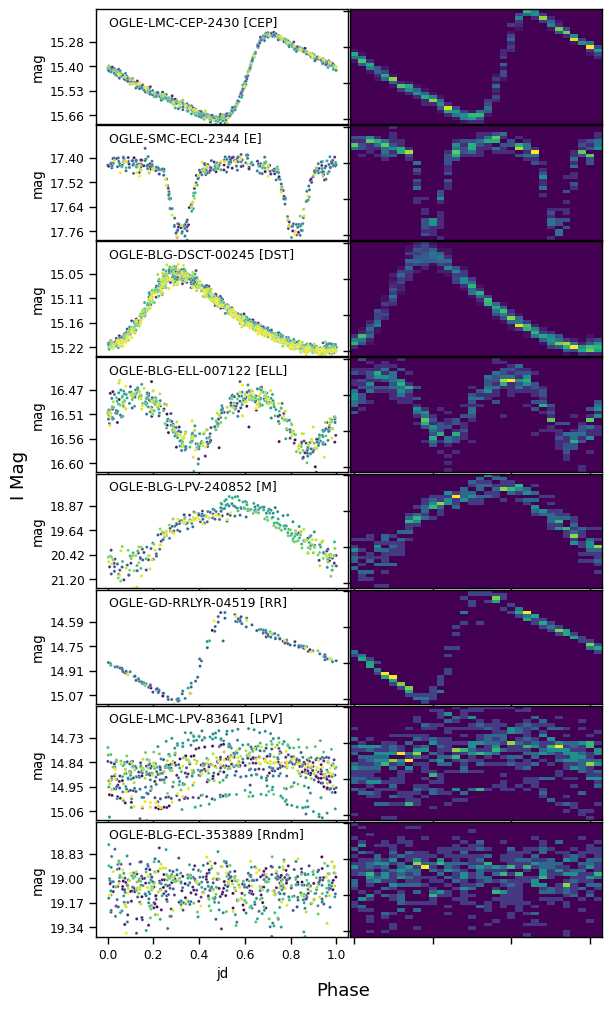

In [338]:



a = plot_histograms(estrellas_plot, path_datos,"max")



In [253]:
import pandas as pd

# Suponiendo que 'catalog' es tu DataFrame

# Calcular los deciles para 'per' y 'amplitud'
per_d10 = catalog.groupby("types")["per"].quantile(0.1)
per_d90 = catalog.groupby("types")["per"].quantile(0.9)
per_median = catalog.groupby("types")["per"].median()

amp_d10 = catalog.groupby("types")["amplitud"].quantile(0.1)
amp_d90 = catalog.groupby("types")["amplitud"].quantile(0.9)
amp_median = catalog.groupby("types")["amplitud"].median()

# Crear un nuevo DataFrame con estos valores
result = pd.DataFrame({
    'Period D10': per_d10,
    'Period D90': per_d90,
    'Period Median': per_median,
    'Amplitude D10': amp_d10,
    'Amplitude D90': amp_d90,
    'Amplitude Median': amp_median
})

# Mantener 4 cifras significativas
result = result.round(4)

# Imprimir en formato LaTeX
print(result.to_latex())



\begin{tabular}{lrrrrrr}
\toprule
 & Period D10 & Period D90 & Period Median & Amplitude D10 & Amplitude D90 & Amplitude Median \\
types &  &  &  &  &  &  \\
\midrule
ELL & 0.465000 & 147.697100 & 5.851300 & 0.071000 & 0.283000 & 0.150000 \\
Mira & 201.300000 & 469.600000 & 331.100000 & 1.585000 & 4.020000 & 2.824000 \\
cep & 0.822400 & 5.963100 & 2.210100 & 0.212800 & 0.688000 & 0.402000 \\
dsct & 0.054300 & 0.141000 & 0.081100 & 0.135000 & 0.759000 & 0.330000 \\
ecl & 0.338500 & 5.316500 & 0.639300 & 0.223000 & 1.027000 & 0.538000 \\
lpv & 11.955000 & 156.230000 & 25.568000 & 0.046000 & 0.436000 & 0.088000 \\
rrlyr & 0.303200 & 0.646700 & 0.523800 & 0.315000 & 0.936000 & 0.629000 \\
\bottomrule
\end{tabular}



In [1]:
df = pd.read_csv(f"{path}/train_number_M.csv")

NameError: name 'pd' is not defined

/tmp/ipykernel_800151/3411862935.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["phi"] = df_plot["g"] / df_plot["per"]
/tmp/ipykernel_800151/3411862935.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["phi"] = df_plot["g"] / df_plot["per"]
/tmp/ipykernel_800151/3411862935.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

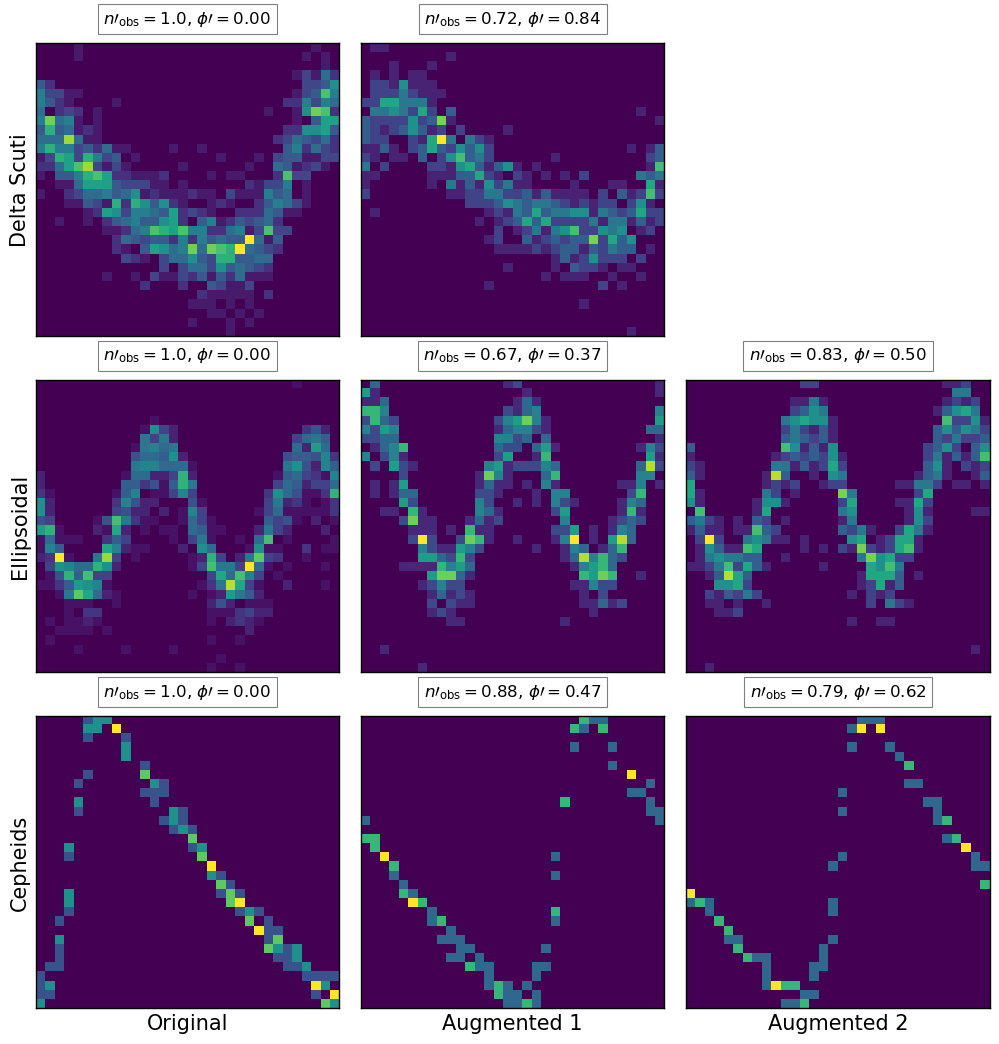

In [228]:
df = pd.read_csv(f"{path}/train_number_M.csv")
data = h5py.File(f"{path}Data.hdf5", 'r+')
ID_cep = 'OGLE-GD-CEP-0028'
ID_dsct = 'OGLE-BLG-DSCT-08845'
ID_ELL = 'OGLE-BLG-ELL-016777'
# Creación de la figura y los ejes
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
plt.tight_layout(pad=0.2)

# Ciclo para cada grupo de estrellas
for fila, stars_group in enumerate([ID_dsct,ID_ELL, ID_cep]):
    df_plot = df.loc[(df["ID"] == stars_group) & (df["types"].str.split("_").str[1] != "random")]
    df_plot.loc[df_plot["bins"].isna(), "bins"] = df_plot["obs_final"]
    df_plot.loc[df_plot["aug"] == 0, "g"] = 0
    df_plot["phi"] = df_plot["g"] / df_plot["per"]
    df_plot = df_plot.sort_values(by="phi")
    df_plot.loc[df_plot["types"] == "cep", "types"] = "Cepheids"
    df_plot.loc[df_plot["types"] == "dsct", "types"] = "Delta Scuti"
    df_plot.loc[df_plot["types"] == "ELL", "types"] = "Ellipsoidal"
    
    for col, star in enumerate(df_plot.index):
        fill_subplot(axes[fila, col], df_plot, star, data)
        axes[fila, col].set_yticks([])
        if col == 0:
            axes[fila, col].set_ylabel(df_plot.loc[star]["types"], fontsize=15)

        if (col == 0) & (fila == 2):
            axes[fila, col].set_xlabel("Original", fontsize=15)
        if (col != 0) & (fila == 2):
            axes[fila, col].set_xlabel(f"Augmented {col}", fontsize=15)

        axes[fila, col].set_xticks([])
    
    # Eliminar los ejes vacíos
    for col in range(len(df_plot.index), 3):
        fig.delaxes(axes[fila, col])

plt.subplots_adjust(hspace=0.15)
plt.savefig(f"{path}Augmented_stars.pdf", bbox_inches="tight")
plt.show()




In [ ]:

rng = np.random.default_rng(42)
datos = f"{path}Data/datos_ogle/datos"
path_datos_4 = datos + "/datos_ogle_4/I"

path_datos_3 = datos + "/datos_ogle_3/I"
path_datos = ["_","_","_",path_datos_3,path_datos_4]

In [3]:
prueba_8mil = pd.read_csv(f"{path}catalogos/prueba_8mil.csv")

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_obs_dist(df, split_name):
    sns.set_context("paper")
    gyr = ['#FFCF3D', "#129675", "#890B96"]
    sns.set_palette(gyr)

    columns = ["obs_final", "amplitud", "mag_mean", "field", "err_mean", "per", "mag_std", "err_std"]
    labels = [r'$n_{obs}$', r'$Amplitude$', 'Mean Magnitude', "Field", 'Mean Error', 'Period', 
              'Magnitude standard deviations', 'Error standard deviations']
    log_scales = [True, True, False, False, True, True, True, False]
    x_ticks = [[10**2, 10**3, 10**4], [10**-1, 1, 10**1], None, None, [10**-2, 10**-1, 10**0], [10**-1, 10**1, 10**3],
               None, [0, 0.3, 0.6]]
    y_scale_log = [True, True, True, True, True, True, True, True]

    fig, axes = plt.subplots(2, 4, figsize=(15, 7))

    # Crear las leyendas una vez
    legend_labels = df[split_name].unique()
    legend_colors = gyr[:len(legend_labels)]

    for i, ax in enumerate(axes.flatten()):
        sns.histplot(ax=ax, data=df, x=columns[i], hue=split_name, bins=30, log_scale=log_scales[i], fill=True, common_norm=True, multiple="stack")
        ax.set(xlabel=labels[i], ylabel="")
        if x_ticks[i] is not None:
            ax.set_xticks(x_ticks[i])
        if y_scale_log[i]:
            ax.set_yscale("log")

            # Calcular y establecer 4 y-ticks para cada subplot
            ymin, ymax = ax.get_ylim()
            yticks = np.logspace(np.log10(ymin+1e-3), np.log10(ymax), 4)  # Añadir un pequeño offset para evitar log(0)            print(yticks)# Añadir un pequeño offset para evitar log(0)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks)
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, _: '${{10^{{{:d}}}}}$'.format(int(np.log10(y)))))

        ax.get_legend().remove()  # Remove the individual legend from each subplot

    plt.rc('xtick', labelsize=13) 

    # Crear una leyenda para toda la figura
    legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=label)
                       for label, color in zip(["Train", "Test", "Validation"], legend_colors)]
    fig.legend(handles=legend_elements, loc='upper center', ncol=len(legend_labels), bbox_to_anchor=(0.5, 1.05))
    fig.tight_layout()
    plt.savefig("Distribution_splits.pdf", bbox_inches="tight")
    plt.show()


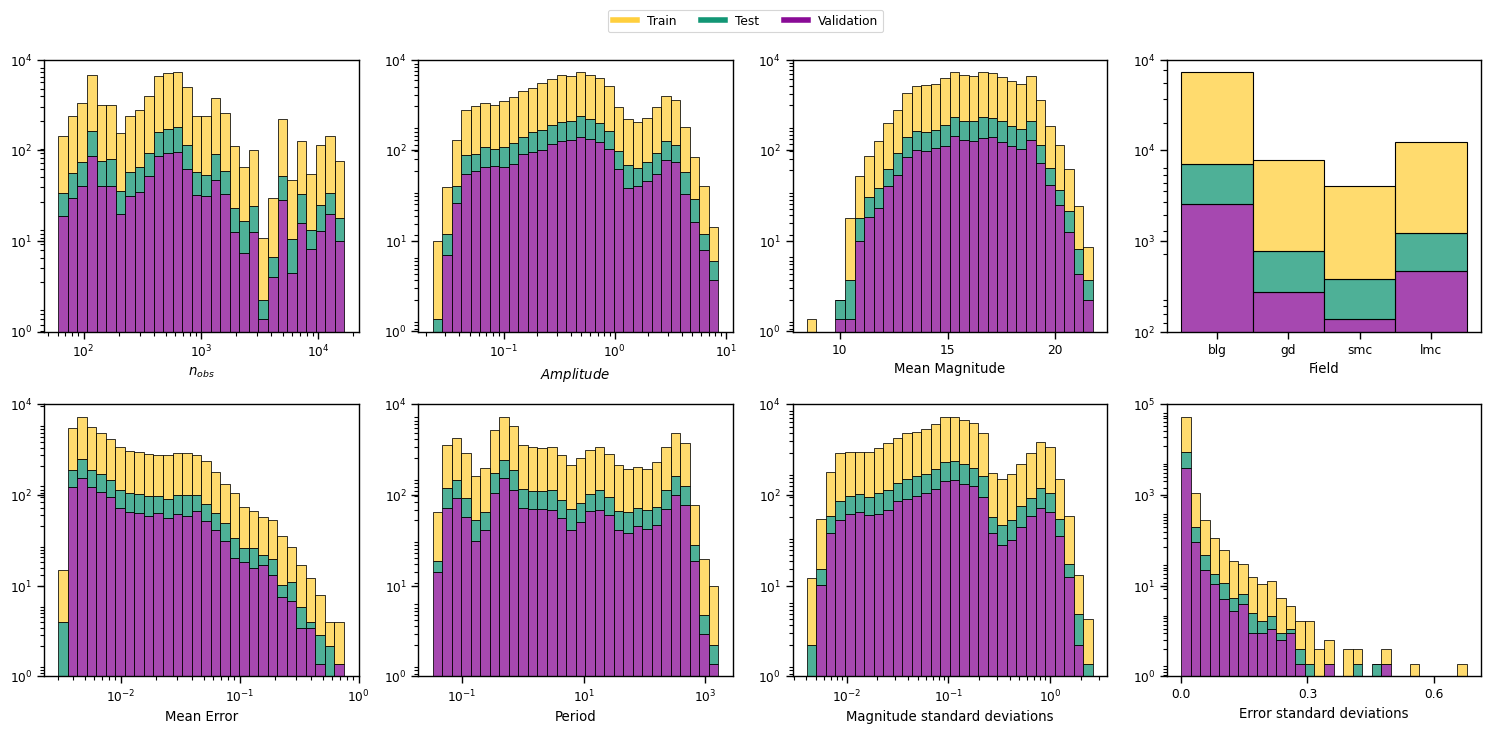

In [89]:
plot_obs_dist(prueba_8mil,"entrenamiento_8mil")

## Resultados

In [107]:
amarillo_train = "#FFCF3D"
purpura_val = "#890B96"
file_names = ["history_softmax_prueba_13080mil",
"history_softmax_prueba_27620mil",
"history_softmax_prueba_69721mil"]
title_names = [
    'Train-9',
    'Train-24',
    'Train-60']
#plot_accuracy_and_loss("entrenamientos/entrenamiento_8_sep/",file_names, title_names, amarillo_train, purpura_val)

In [136]:
ls {path}/catalogos/DataSets

prueba_23mil.csv  prueba_60mil.csv  prueba_8mil.csv


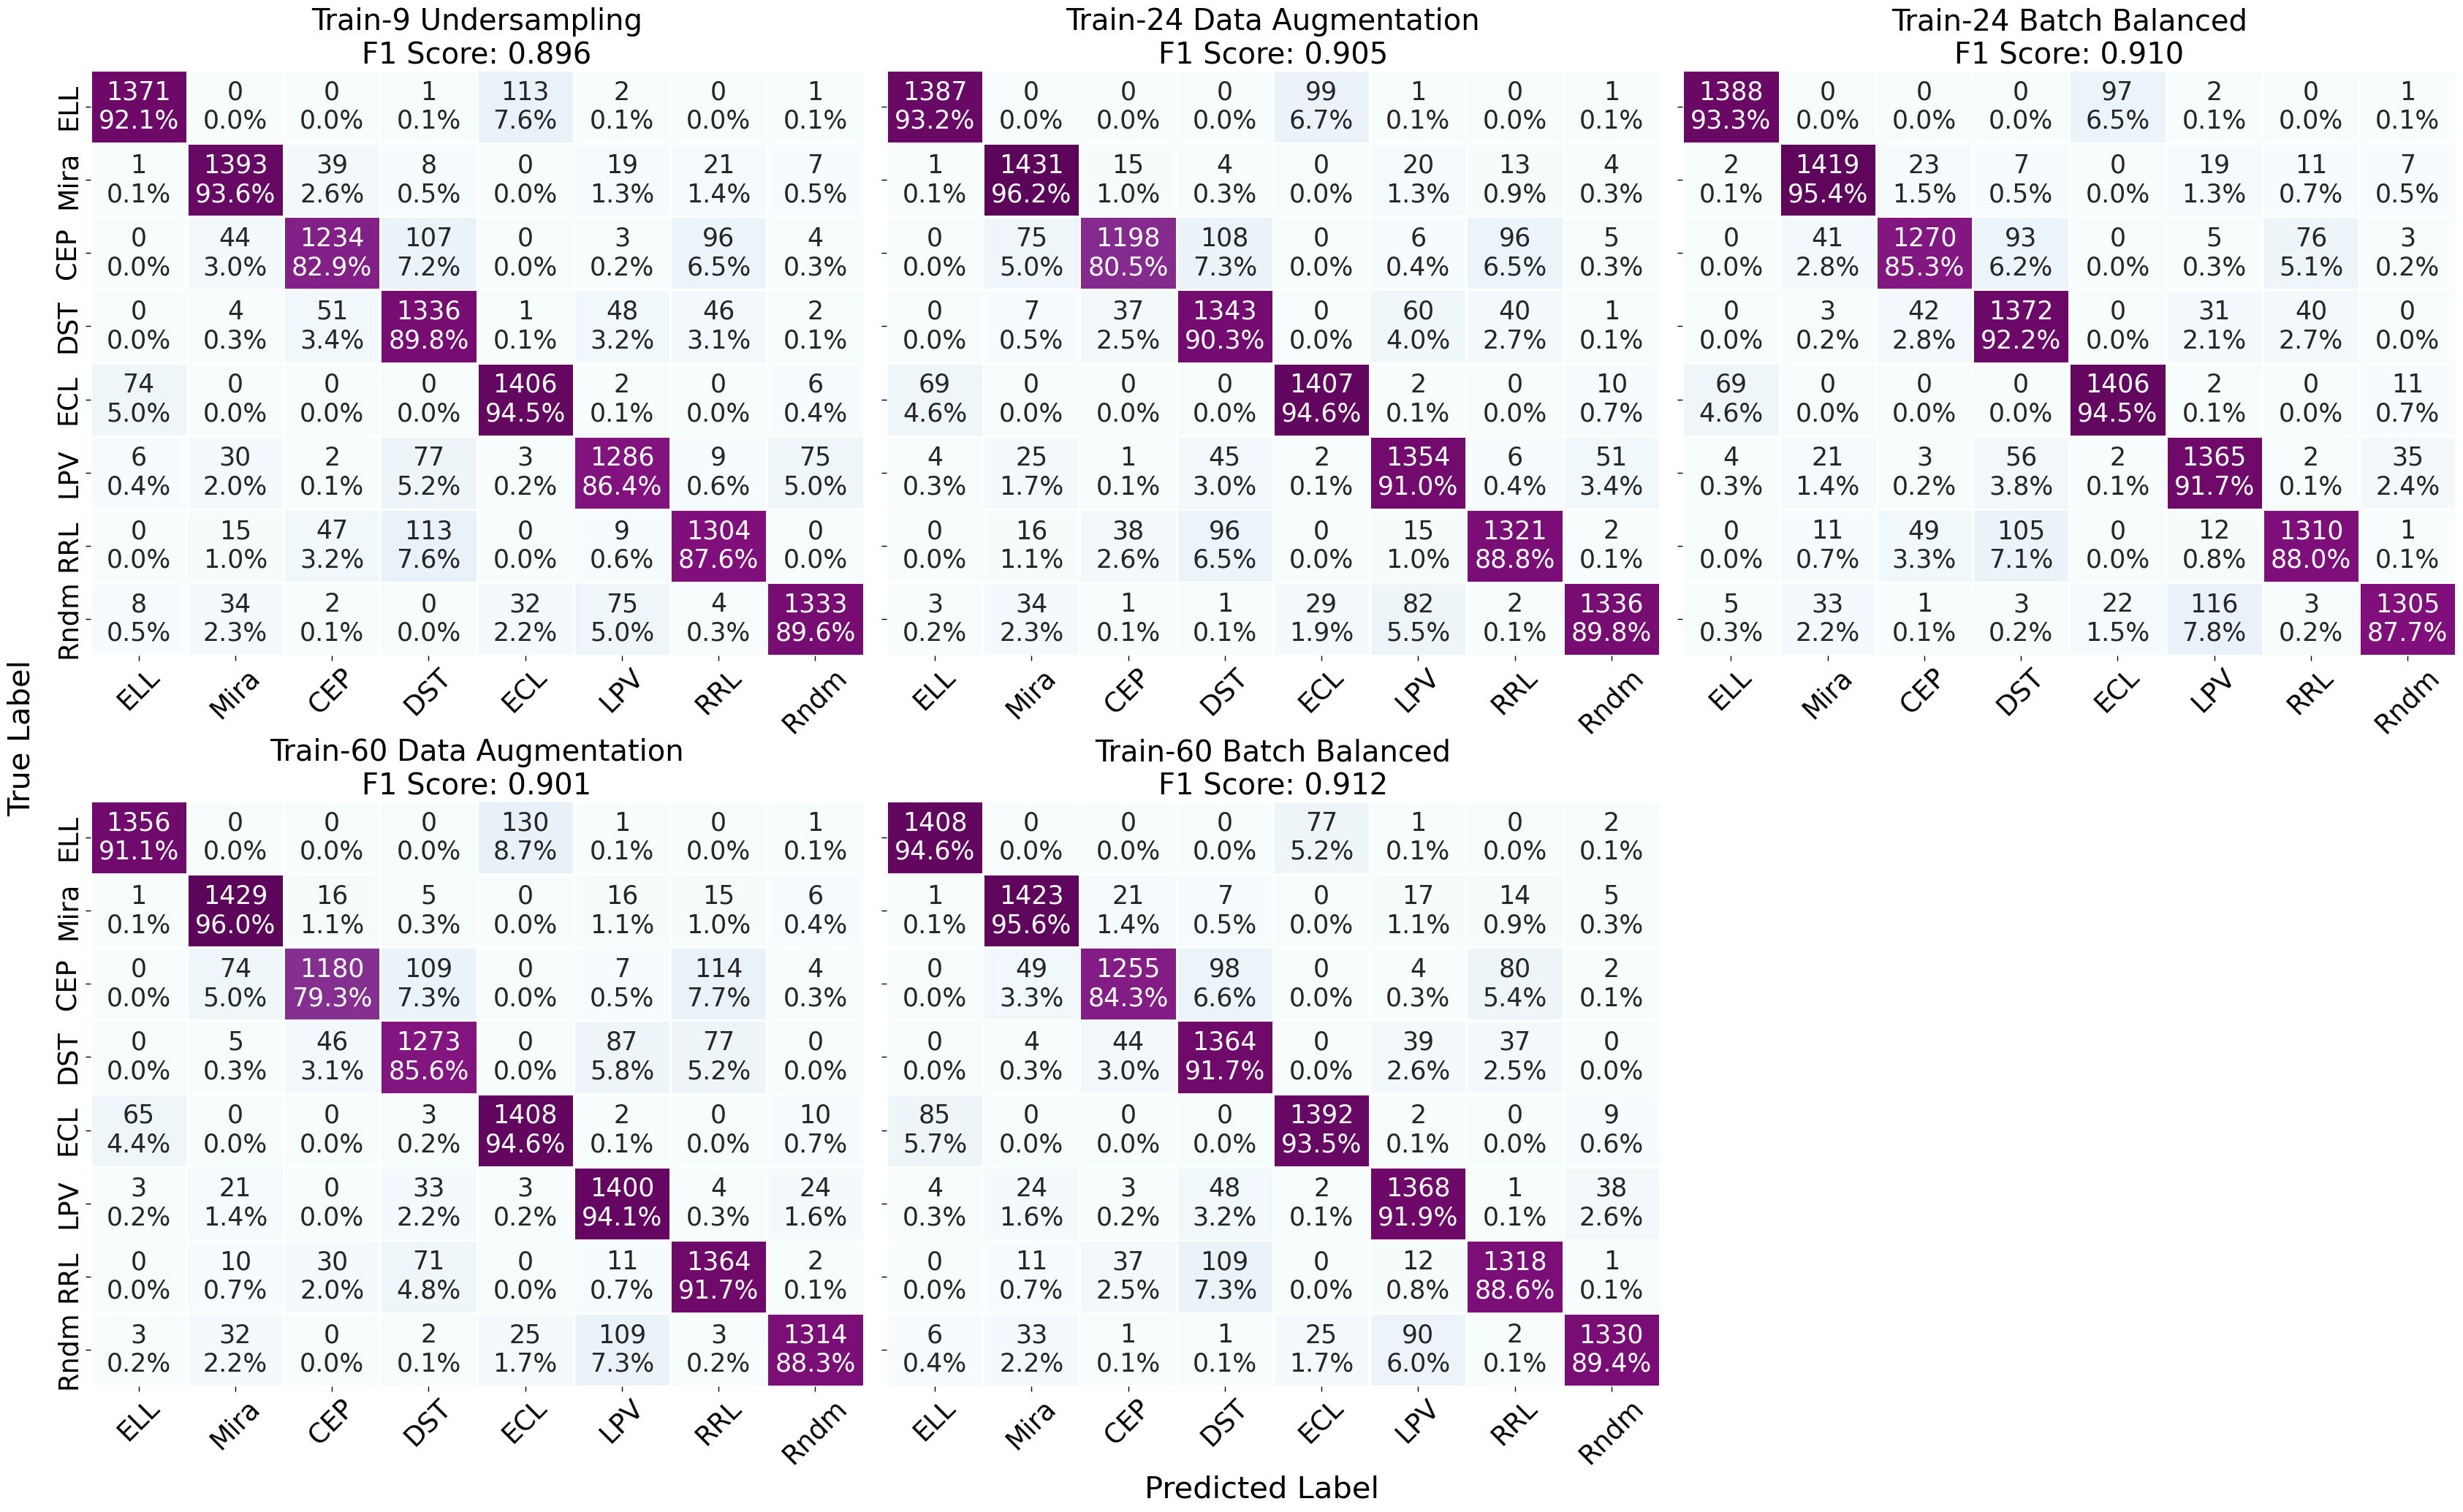

In [139]:
tests = ['training_softmax_prueba_13080mil','training_softmax_prueba_27620mil',
         'training_softmax_batchBalanced_prueba_27620mil',
         'training_softmax_prueba_69721mil',
         'training_softmax_batchBalanced_prueba_69721mil']
titles = ['Train-9 Undersampling','Train-24 Data Augmentation',
         'Train-24 Batch Balanced',
         'Train-60 Data Augmentation',
         'Train-60 Batch Balanced']

test = run_analysis(tests,titles,
                    f"{path}/../../git/Paper_OGLE/entrenamientos/entrenamiento_8_sep/",
                    f"{path}Data_08Sep.hdf5",
                    f"{path}/catalogos/DataSets/prueba_8mil.csv"
                   )


In [140]:
df = metricas(test["categorical_label"],test["label_predict_training_softmax_batchBalanced_prueba_27620mil"])

Accuracy: 0.91
macro precision:  0.91
macro recall:  0.91
macro F1:  0.91
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1488
           1       0.93      0.95      0.94      1488
           2       0.91      0.85      0.88      1488
           3       0.84      0.92      0.88      1488
           4       0.92      0.94      0.93      1488
           5       0.88      0.92      0.90      1488
           6       0.91      0.88      0.89      1488
           7       0.96      0.88      0.92      1488

    accuracy                           0.91     11904
   macro avg       0.91      0.91      0.91     11904
weighted avg       0.91      0.91      0.91     11904



In [141]:
print(pd.DataFrame(df).T.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.945504 & 0.932796 & 0.939107 & 1488.000000 \\
1 & 0.928665 & 0.953629 & 0.940981 & 1488.000000 \\
2 & 0.914986 & 0.853495 & 0.883171 & 1488.000000 \\
3 & 0.838631 & 0.922043 & 0.878361 & 1488.000000 \\
4 & 0.920760 & 0.944892 & 0.932670 & 1488.000000 \\
5 & 0.879510 & 0.917339 & 0.898026 & 1488.000000 \\
6 & 0.908460 & 0.880376 & 0.894198 & 1488.000000 \\
7 & 0.957447 & 0.877016 & 0.915468 & 1488.000000 \\
accuracy & 0.910198 & 0.910198 & 0.910198 & 0.910198 \\
macro avg & 0.911745 & 0.910198 & 0.910248 & 11904.000000 \\
weighted avg & 0.911745 & 0.910198 & 0.910248 & 11904.000000 \\
\bottomrule
\end{tabular}



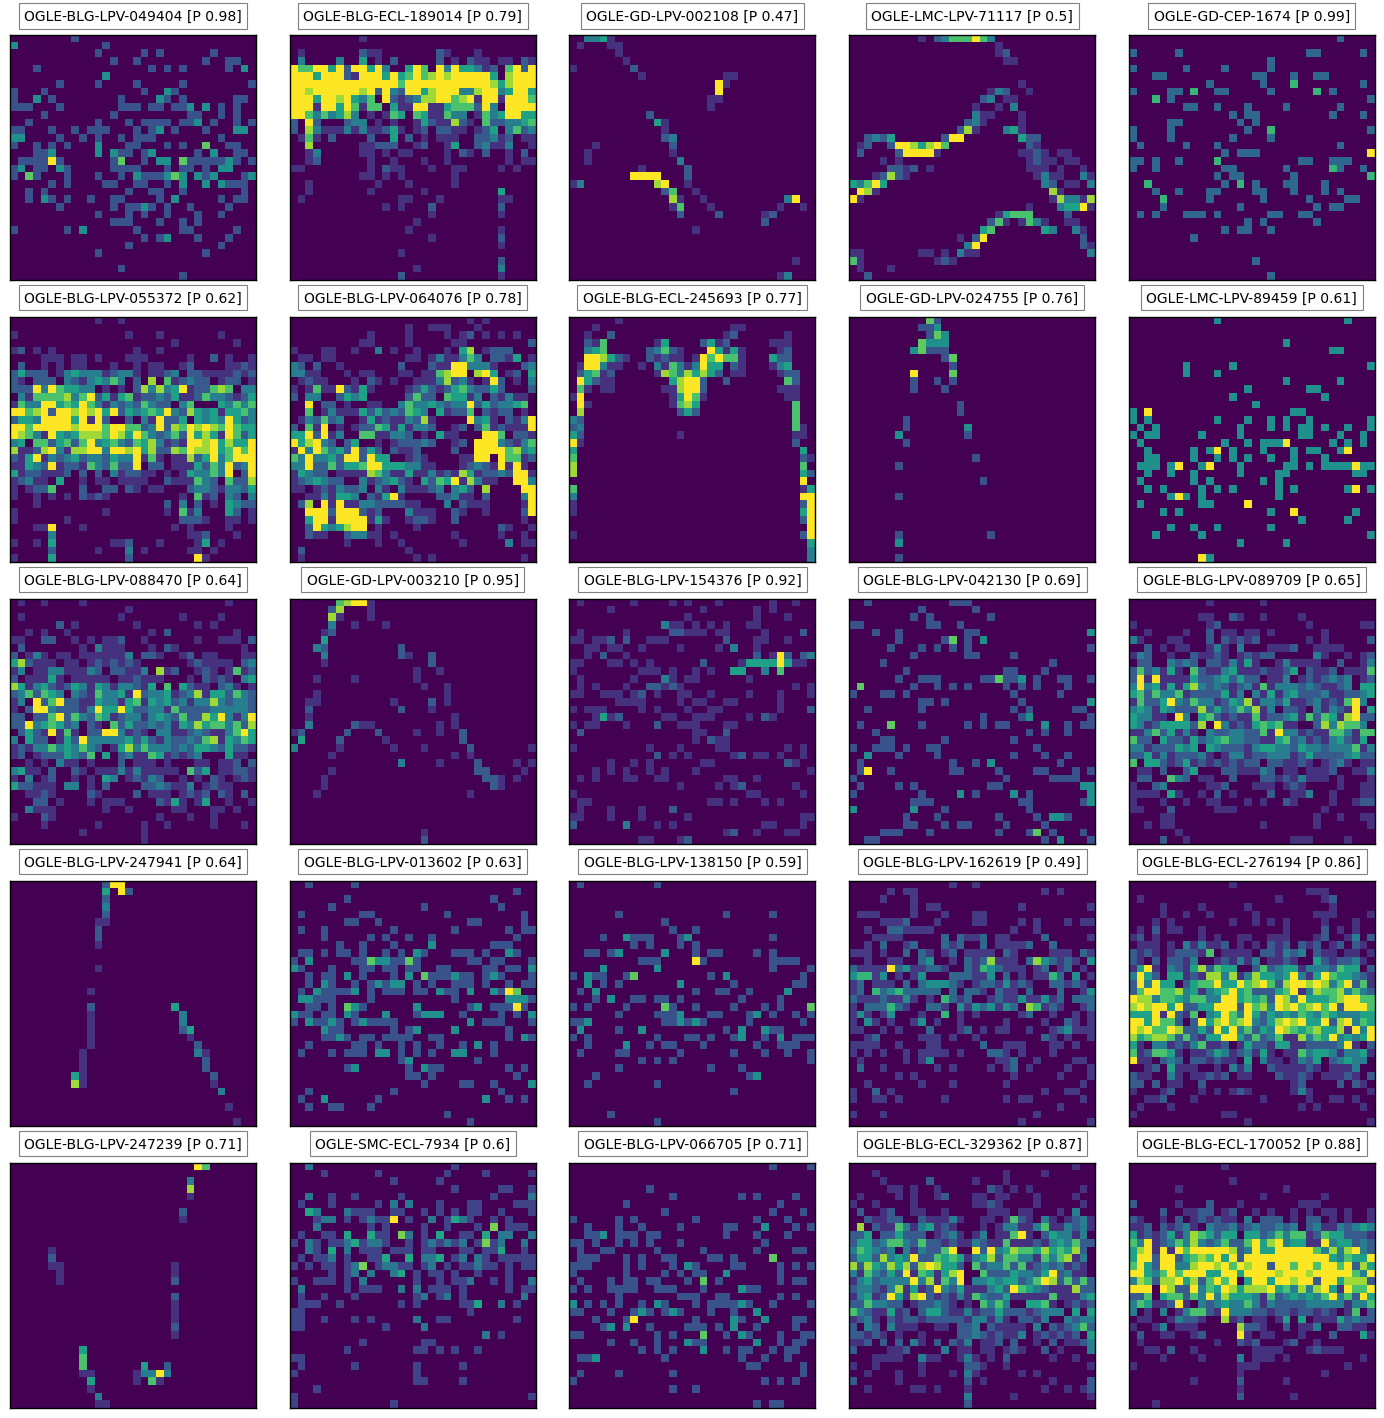

In [446]:
import matplotlib.pyplot as plt

# Suponiendo que 'data' y 'miss_class' están definidos correctamente

# Creación de la figura y los ejes
fig, axes = plt.subplots(5, 5, figsize=(14, 14), sharex=True, sharey=True)

# Aplanar el array de ejes para facilitar la iteración
axes_flat = axes.flatten()

# Ciclo para cada grupo de estrellas
for idx, star in enumerate(miss_class.index):
    # Asegurarse de que no se exceda el número de ejes disponibles
    if idx < len(axes_flat):
        axes_flat[idx].imshow(data["prueba_13080mil"][star], aspect="auto")
        axes_flat[idx].set_xticks([])
        axes_flat[idx].set_yticks([])
        predict = round(miss_class["porcentaje_predict_training_softmax_batchBalanced_prueba_69721mil"][star],2)
        tex = miss_class["ID"][star]+ " "+"[P " + str(predict)+"]"
        text_str = tex
    axes_flat[idx].text(0.5, 1.05, text_str, transform=axes_flat[idx].transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='center', 
            bbox=dict(facecolor='white', alpha=0.5))

# Ajustes adicionales de la figura
plt.tight_layout(pad=0.15)
plt.subplots_adjust(hspace=0.15)
plt.savefig("Predicted_as_random.pdf", bbox_inches="tight")
plt.show()


In [ ]:
f"{path}/../../git/Paper_OGLE/entrenamientos/entrenamiento_8_sep/",
                    f"{path}Data_08Sep.hdf5",
                    f"{path}/catalogos/DataSets/prueba_8mil.csv"

In [160]:
#data = h5py.File("../data_Paper_OGLE/Data_08Sep.hdf5", 'r+')
#ogle = pd.read_csv("catalogos/ogle_no_usado.csv")
df_8mil = pd.read_csv(f"{path}/catalogos/DataSets/prueba_8mil.csv")
idx_test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"].index.values
model_softmax = make_model()
model_softmax.load_weights(f"{path}/../../git/Paper_OGLE/entrenamientos/entrenamiento_8_sep/training_softmax_batchBalanced_prueba_27620mil/cp.ckpt")
df = pd.DataFrame(model_softmax.predict(data["prueba_13080mil"][:]),columns=['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random"])
df_8mil = pd.concat([df_8mil,df],axis=1)
df_8mil = df_8mil.loc[df_8mil["categorical_label"]!=7]
X_train = df_8mil.loc[df_8mil["prueba_8mil"]!="test"][['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random",
         "per","amplitud","types","categorical_label"]]
X_test = df_8mil.loc[df_8mil["prueba_8mil"]=="test"][['ELL', 'Mira', 'cep', 'dsct', 'ecl', 'lpv', 'rrlyr',"Random",
         "per","amplitud","types","categorical_label"]]

In [161]:
X_test

,ELL,Mira,cep,dsct,ecl,lpv,rrlyr,Random,per,amplitud,types,categorical_label
6,2.723986e-04,1.049594e-14,7.219313e-14,1.519476e-12,9.997275e-01,2.169540e-12,6.886375e-15,5.944822e-11,0.426101,0.863,ecl,4
11,5.086940e-05,2.551360e-12,1.713711e-14,6.517447e-17,9.999491e-01,2.309529e-09,1.061885e-16,2.331338e-10,0.574601,0.894,ecl,4
16,1.220247e-03,2.402624e-08,1.542982e-09,3.034349e-05,1.249477e-01,2.080750e-02,6.775367e-08,8.529941e-01,217.713940,0.137,ecl,4
25,6.793228e-03,5.545616e-10,6.420836e-12,6.178395e-11,9.932064e-01,1.746676e-08,1.465342e-10,3.399267e-07,0.407592,0.657,ecl,4
26,2.116934e-03,1.072764e-14,1.285526e-14,4.844122e-12,9.978830e-01,8.824531e-12,3.752517e-13,6.743773e-10,1.161228,0.178,ecl,4
...,...,...,...,...,...,...,...,...,...,...,...,...
80078,1.173109e-04,2.766868e-04,2.855800e-03,1.439554e-01,1.605881e-04,8.443494e-01,8.067787e-03,2.169938e-04,115.160000,0.274,lpv,5
80082,1.128164e-06,1.028469e-06,1.653618e-04,3.257132e-03,4.555328e-06,9.943915e-01,4.611811e-05,2.133176e-03,15.976000,0.058,lpv,5
80091,1.004801e-06,1.116740e-07,1.026062e-05,9.715824e-04,1.789106e-05,9.981526e-01,2.815519e-06,8.436771e-04,23.485000,0.085,lpv,5
80099,2.333280e-06,2.685732e-08,2.058074e-06,2.572711e-05,2.731292e-05,9.952452e-01,1.497755e-06,4.695841e-03,25.305000,0.073,lpv,5


In [ ]:
def train_tree(X_train, y_train, X_test, y_test, max_depth, random_state=42):


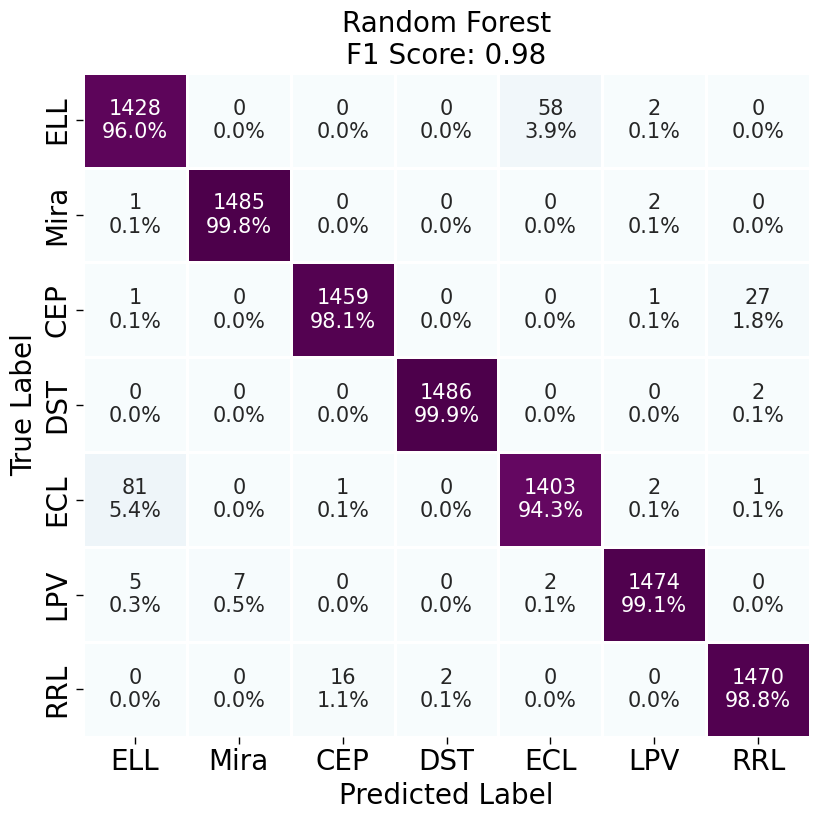

In [460]:
a,b = train_random_forest(X_train.drop(columns={"types","categorical_label"}),
                   X_train["categorical_label"],
                   X_test.drop(columns={"types","categorical_label"}),
                   X_test["categorical_label"],7)

In [467]:
catalo

,ID,RA,DEC,types,database,field,Subtype,per,l,b,error,obs_eliminadas,amplitud,mag_mean,mag_std,err_mean,err_std,obs_final,obs_inicial,categorical_label
0,OGLE-LMC-ECL-17495,05:30:01.51,-69:30:57.2,ecl,4,lmc,NC,1.029283,-1.395018,-0.565071,1,3.0,0.353,18.177608,0.066634,0.030425,0.006698,609.0,612.0,4
1,OGLE-BLG-ECL-270986,18:03:00.33,-28:07:41.1,ecl,4,blg,NC,1.944729,0.045888,-0.050359,1,526.0,0.202,15.089699,0.019399,0.004058,0.000238,10010.0,10536.0,4
2,OGLE-BLG-ECL-270978,18:03:00.30,-28:05:36.3,ecl,4,blg,NC,0.379665,0.046415,-0.050060,1,66.0,0.337,18.287165,0.053646,0.027392,0.006585,10471.0,10537.0,4
3,OGLE-BLG-ECL-270979,18:03:00.31,-32:58:13.6,ecl,4,blg,NC,2.464727,-0.028040,-0.091660,1,12.0,0.560,18.191190,0.091937,0.026330,0.007748,373.0,385.0,4
4,OGLE-BLG-ECL-270980,18:03:00.32,-34:40:16.2,ecl,4,blg,NC,1.078398,-0.054124,-0.106060,1,0.0,0.308,17.712623,0.062966,0.021575,0.005255,252.0,252.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055934,OGLE-LMC-ECL-00041,04:33:50.14,-67:53:54.0,ecl,3,lmc,EC,0.365729,-1.399284,-0.658162,1,0.0,0.486,15.386158,0.133404,0.006551,0.000569,450.0,450.0,4
1055935,OGLE-LMC-ECL-00029,04:33:06.86,-69:41:17.1,ecl,3,lmc,ED,2.860338,-1.362424,-0.647225,1,4.0,1.155,19.122611,0.186475,0.097419,0.024627,167.0,171.0,4
1055936,OGLE-LMC-ECL-00012,04:31:28.89,-69:01:33.5,ecl,3,lmc,ESD,4.744795,-1.374519,-0.654099,1,8.0,1.251,19.902106,0.192003,0.133802,0.043903,424.0,432.0,4
1055937,OGLE-LMC-ECL-00008,04:31:13.02,-70:03:32.6,ecl,3,lmc,ELL_EC,2.806298,-1.353557,-0.647236,1,1.0,0.068,16.288839,0.012584,0.009227,0.001140,428.0,429.0,4


In [466]:
prueba_8mil.loc[(prueba_8mil["types"]=="cep")]#&(prueba_8mil["prueba_8mil"]=="train")]

,ID,RA,DEC,types,database,field,Subtype,per,error,obs_eliminadas,...,ra_deg,dec_deg,GroupID,GroupSize,categorical_label,prueba_8mil,aug,g,bins,N
19965,OGLE-SMC-CEP-4851,01:18:57.39,-70:19:21.9,cep,4,smc,1O,0.895894,1,0,...,19.739125,-70.322750,NaN,NaN,2,train,0,NaN,NaN,NaN
19966,OGLE-SMC-CEP-4852,01:19:17.53,-71:15:23.6,cep,4,smc,1O/2O,0.458678,1,0,...,19.823042,-71.256556,NaN,NaN,2,train,0,NaN,NaN,NaN
19967,OGLE-SMC-CEP-4853,01:19:18.93,-70:51:37.6,cep,4,smc,F/1O,1.612018,1,0,...,19.828875,-70.860444,NaN,NaN,2,train,0,NaN,NaN,NaN
19968,OGLE-SMC-CEP-4854,01:20:07.87,-74:16:07.0,cep,4,smc,1O,0.686529,1,0,...,20.032792,-74.268611,NaN,NaN,2,train,0,NaN,NaN,NaN
19969,OGLE-SMC-CEP-4855,01:20:16.90,-74:18:22.3,cep,4,smc,1O,0.653218,1,0,...,20.070417,-74.306194,NaN,NaN,2,train,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69279,OGLE-LMC-CEP-0059,04:44:54.90,-68:38:21.7,cep,3,lmc,F,4.390393,1,0,...,71.228750,-68.639361,NaN,NaN,2,train,0,NaN,NaN,NaN
69280,OGLE-LMC-CEP-0073,04:46:38.50,-67:08:43.9,cep,3,lmc,1O/2O,0.837148,1,0,...,71.660417,-67.145528,NaN,NaN,2,train,0,NaN,NaN,NaN
69281,OGLE-LMC-CEP-0036,04:42:11.79,-70:14:02.0,cep,3,lmc,F/1O,1.573822,1,0,...,70.549125,-70.233889,NaN,NaN,2,train,0,NaN,NaN,NaN
69282,OGLE-GD-CEP-0017,13:27:30.10,-64:40:37.7,cep,3,gd,1O,1.915025,1,0,...,201.875417,-64.677139,NaN,NaN,2,train,0,NaN,NaN,NaN


In [202]:
X_train

,ELL,Mira,cep,dsct,ecl,lpv,rrlyr,Random,per,amplitud,types,categorical_label
0,1.642817e-01,1.572727e-09,2.296300e-10,4.981265e-06,8.357080e-01,6.587572e-08,1.439532e-08,5.205571e-06,0.428245,0.576,ecl,4
1,7.013346e-05,3.915452e-15,5.605886e-16,3.305101e-05,9.504156e-01,2.538087e-09,4.124067e-14,4.948131e-02,3.463970,0.662,ecl,4
2,4.658592e-06,9.737916e-22,5.952192e-22,8.390437e-17,9.999954e-01,5.952139e-17,2.499581e-20,2.940820e-12,1.560932,0.723,ecl,4
3,6.215497e-01,2.834021e-09,3.658616e-09,1.358648e-09,3.784485e-01,2.946799e-08,6.666316e-10,1.654385e-06,0.260708,0.184,ecl,4
4,1.466834e-08,2.368128e-21,3.016977e-23,4.755060e-20,1.000000e+00,1.037125e-16,3.419298e-22,7.601812e-12,1.181536,1.226,ecl,4
...,...,...,...,...,...,...,...,...,...,...,...,...
80110,9.438141e-06,1.411484e-05,6.001598e-03,5.174115e-01,2.308806e-06,4.642476e-01,1.231173e-02,1.650714e-06,40.150000,0.106,lpv,5
80111,9.143809e-07,1.686532e-07,2.920850e-04,5.437627e-02,3.395374e-06,9.450446e-01,9.196552e-05,1.907397e-04,27.258000,0.076,lpv,5
80112,1.042230e-05,3.806272e-04,2.167285e-03,1.316011e-01,3.749256e-05,8.620260e-01,3.646558e-03,1.305378e-04,185.740000,0.435,lpv,5
80113,2.154076e-05,2.378728e-05,1.227048e-03,5.295302e-03,4.007520e-05,9.912550e-01,8.851961e-04,1.251945e-03,80.420000,0.297,lpv,5


In [203]:
feature_names = X_train.drop(columns={"types","categorical_label"}).keys().values.tolist()
class_names = X_train["types"].values.tolist()

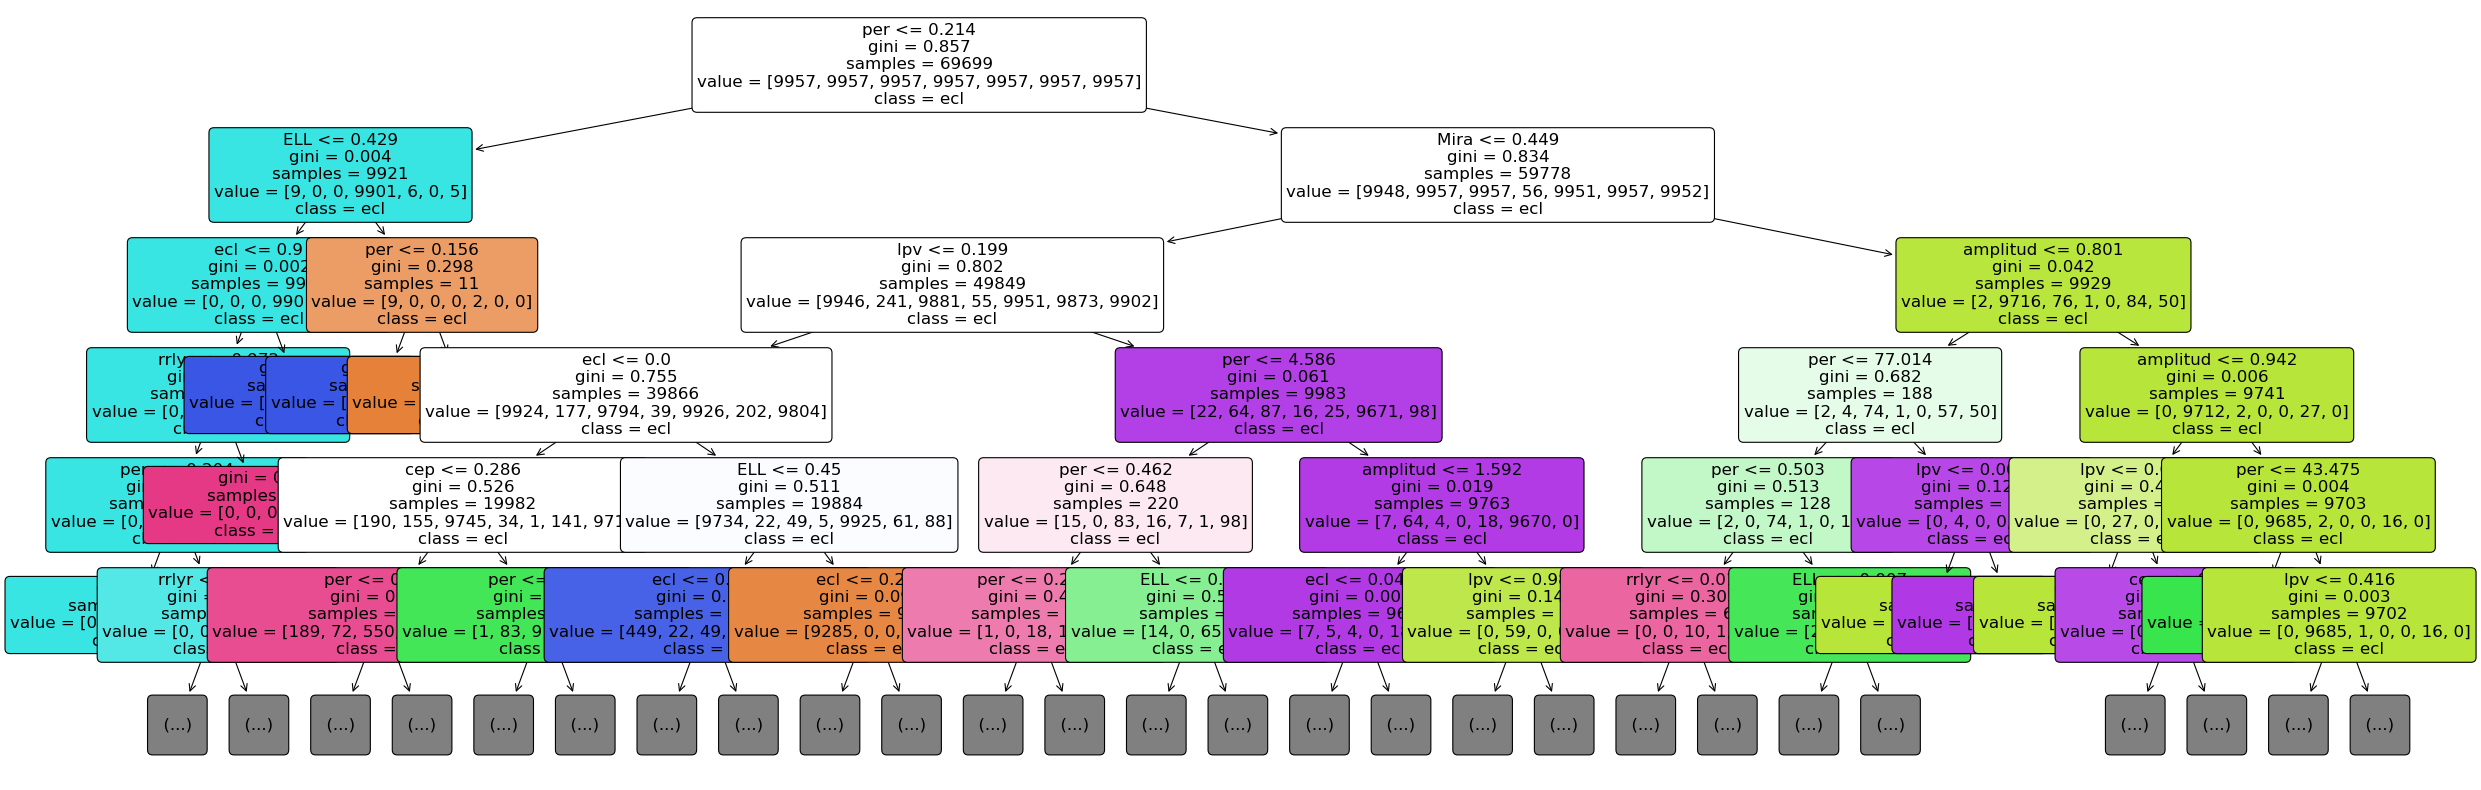

In [208]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Ajustar el tamaño de la figura
plt.figure(figsize=(30, 10))  # Puedes ajustar estos valores según tus necesidades

# Graficar el árbol
plot_tree(a, 
          filled=True,  # Rellena los nodos con el color de la clase mayoritaria
          rounded=True, # Redondea las esquinas de los nodos
          feature_names=feature_names, # Lista con los nombres de las características
          class_names=class_names, # Lista con los nombres de las clases
          fontsize=12,
          max_depth=5) # Tamaño de la fuente de los textos

# Mostrar el gráfico
plt.show()


In [494]:
ls {path}/catalogos/DataSets/

prueba_23mil.csv  prueba_60mil.csv  prueba_8mil.csv


In [506]:
df_8mil = pd.read_csv(f"{path}/catalogos/DataSets/prueba_8mil.csv")


In [515]:
df_8mil.loc[(df_8mil["types"]=="cep")&(df_8mil["obs_final"]>60)]

,ID,RA,DEC,types,database,field,Subtype,per,error,obs_eliminadas,...,ra_deg,dec_deg,GroupID,GroupSize,categorical_label,prueba_8mil,aug,g,bins,N
19965,OGLE-SMC-CEP-4851,01:18:57.39,-70:19:21.9,cep,4,smc,1O,0.895894,1,0,...,19.739125,-70.322750,NaN,NaN,2,train,0,NaN,NaN,NaN
19966,OGLE-SMC-CEP-4852,01:19:17.53,-71:15:23.6,cep,4,smc,1O/2O,0.458678,1,0,...,19.823042,-71.256556,NaN,NaN,2,train,0,NaN,NaN,NaN
19967,OGLE-SMC-CEP-4853,01:19:18.93,-70:51:37.6,cep,4,smc,F/1O,1.612018,1,0,...,19.828875,-70.860444,NaN,NaN,2,train,0,NaN,NaN,NaN
19968,OGLE-SMC-CEP-4854,01:20:07.87,-74:16:07.0,cep,4,smc,1O,0.686529,1,0,...,20.032792,-74.268611,NaN,NaN,2,train,0,NaN,NaN,NaN
19969,OGLE-SMC-CEP-4855,01:20:16.90,-74:18:22.3,cep,4,smc,1O,0.653218,1,0,...,20.070417,-74.306194,NaN,NaN,2,train,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69279,OGLE-LMC-CEP-0059,04:44:54.90,-68:38:21.7,cep,3,lmc,F,4.390393,1,0,...,71.228750,-68.639361,NaN,NaN,2,train,0,NaN,NaN,NaN
69280,OGLE-LMC-CEP-0073,04:46:38.50,-67:08:43.9,cep,3,lmc,1O/2O,0.837148,1,0,...,71.660417,-67.145528,NaN,NaN,2,train,0,NaN,NaN,NaN
69281,OGLE-LMC-CEP-0036,04:42:11.79,-70:14:02.0,cep,3,lmc,F/1O,1.573822,1,0,...,70.549125,-70.233889,NaN,NaN,2,train,0,NaN,NaN,NaN
69282,OGLE-GD-CEP-0017,13:27:30.10,-64:40:37.7,cep,3,gd,1O,1.915025,1,0,...,201.875417,-64.677139,NaN,NaN,2,train,0,NaN,NaN,NaN


In [508]:
df_8mil.groupby("prueba_8mil").count() /8

,ID,RA,DEC,types,database,field,Subtype,per,error,obs_eliminadas,...,obs_inicial,ra_deg,dec_deg,GroupID,GroupSize,categorical_label,aug,g,bins,N
prueba_8mil,,,,,,,,,,,,,,,,,,,,,
test,1488.0,1488.0,1488.0,1488.0,1488.0,1488.0,1264.625,1488.0,1488.0,1488.0,...,1488.0,1488.0,1488.0,5.375,5.375,1488.0,1488.0,0.0,0.0,0.0
train,8463.0,8463.0,8463.0,8463.0,8463.0,8463.0,7187.875,8463.0,8463.0,8463.0,...,8463.0,8463.0,8463.0,36.250,36.250,8463.0,8463.0,0.0,0.0,0.0
val,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1270.125,1494.0,1494.0,1494.0,...,1494.0,1494.0,1494.0,8.250,8.250,1494.0,1494.0,0.0,0.0,0.0


In [482]:
df_8mil["types"].unique()

array(['ecl', 'rrlyr', 'Mira', 'dsct', 'cep', 'ELL', 'lpv', 'ELL_random',
       'Mira_random', 'cep_random', 'dsct_random', 'ecl_random',
       'lpv_random', 'rrlyr_random'], dtype=object)